# Práctico 4: Análisis PCA del Titanic

Este notebook desarrolla el práctico de PCA utilizando el dataset del Titanic disponible en seaborn. Se documenta cada paso para garantizar una codificación sin sesgo y responder cada punto de la consigna.

## Objetivos

- Analizar las variables del dataset y decidir una codificación numérica sin introducir sesgos.
- Preparar el dataset (imputación y escalado) para aplicar PCA.
- Ejecutar PCA, evaluar la varianza explicada y visualizar biplots (PC1 vs PC2 y PC2 vs PC3).
- Interpretar patrones, relaciones entre variables y características de los supervivientes.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

sns.set_theme(style='whitegrid', palette='Set2')

In [2]:
# Cargar dataset Titanic
df = sns.load_dataset('titanic')
print('Dimensiones originales:', df.shape)
df.head()

Dimensiones originales: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Revisión de variables

Se revisan tipos de datos, cantidad de valores distintos y valores faltantes para fundamentar la codificación.

In [3]:
variable_summary = (
    pd.DataFrame({
        'dtype': df.dtypes,
        'valores_unicos': df.nunique(dropna=True),
        'nulos': df.isnull().sum()
    })
    .reset_index()
    .rename(columns={'index': 'variable'})
)
variable_summary

,variable,dtype,valores_unicos,nulos
0,survived,int64,2,0
1,pclass,int64,3,0
2,sex,object,2,0
3,age,float64,88,177
4,sibsp,int64,7,0
5,parch,int64,7,0
6,fare,float64,248,0
7,embarked,object,3,2
8,class,category,3,0
9,who,object,3,0


## Plan de codificación sin sesgo

Se define una estrategia específica para cada variable categórica/booleana, evitando introducir jerarquías artificiales y preservando la información sobre valores faltantes.

In [4]:
encoding_plan = pd.DataFrame([
    {'Variable': 'sex', 'Tipo': 'Binaria', 'Estrategia': "Crear 'sex_female' = 1 si es mujer; eliminar columna original."},
    {'Variable': 'adult_male', 'Tipo': 'Booleana', 'Estrategia': 'Convertir True/False a 1/0.'},
    {'Variable': 'alone', 'Tipo': 'Booleana', 'Estrategia': 'Convertir True/False a 1/0.'},
    {'Variable': 'who', 'Tipo': 'Categórica (3 valores)', 'Estrategia': 'One-hot conservando las tres categorías (child, man, woman) para no fijar referencia.'},
    {'Variable': 'deck', 'Tipo': 'Categórica con muchos NaN', 'Estrategia': "Tratar NaN como 'Unknown' y aplicar one-hot."},
    {'Variable': 'embark_town', 'Tipo': 'Categórica con algunos NaN', 'Estrategia': "Imputar 'Unknown' y aplicar one-hot."},
    {'Variable': 'embarked', 'Tipo': 'Duplicada de embark_town', 'Estrategia': 'Eliminar para evitar colinealidad.'},
    {'Variable': 'class', 'Tipo': 'Duplicada de pclass', 'Estrategia': 'Eliminar y conservar pclass como ordinal.'},
    {'Variable': 'alive', 'Tipo': 'Duplicada de survived', 'Estrategia': 'Eliminar para evitar duplicar la variable objetivo.'}
])
encoding_plan

,Variable,Tipo,Estrategia
0,sex,Binaria,Crear 'sex_female' = 1 si es mujer; eliminar c...
1,adult_male,Booleana,Convertir True/False a 1/0.
2,alone,Booleana,Convertir True/False a 1/0.
3,who,Categórica (3 valores),One-hot conservando las tres categorías (child...
4,deck,Categórica con muchos NaN,Tratar NaN como 'Unknown' y aplicar one-hot.
5,embark_town,Categórica con algunos NaN,Imputar 'Unknown' y aplicar one-hot.
6,embarked,Duplicada de embark_town,Eliminar para evitar colinealidad.
7,class,Duplicada de pclass,Eliminar y conservar pclass como ordinal.
8,alive,Duplicada de survived,Eliminar para evitar duplicar la variable obje...


### Conversión a variables numéricas

Se aplica el plan anterior paso a paso, manteniendo indicadores explícitos para categorías y valores faltantes.

In [5]:
df_ready = df.copy()

# Eliminar columnas duplicadas respecto a métricas ya numéricas
df_ready = df_ready.drop(columns=['embarked', 'class', 'alive'])

# Codificación binaria de 'sex' (sin valores faltantes)
df_ready['sex_female'] = (df_ready['sex'] == 'female').astype(int)
df_ready = df_ready.drop(columns=['sex'])

# Convertir booleanos a 0/1
for col in ['adult_male', 'alone']:
    df_ready[col] = df_ready[col].astype(int)

# One-hot de 'who' sin eliminar categorías para evitar referencias implícitas
df_ready = pd.get_dummies(df_ready, columns=['who'], drop_first=False, dtype=int)

# One-hot de 'deck' tratando valores faltantes como categoría propia
df_ready['deck'] = df_ready['deck'].cat.add_categories(['Unknown']).fillna('Unknown')
df_ready = pd.get_dummies(df_ready, columns=['deck'], drop_first=False, dtype=int)

# One-hot de 'embark_town' con categoría 'Unknown' explícita
df_ready['embark_town'] = df_ready['embark_town'].fillna('Unknown')
df_ready = pd.get_dummies(df_ready, columns=['embark_town'], drop_first=False, dtype=int)

print('Dimensiones tras codificación:', df_ready.shape)
df_ready.head()

Dimensiones tras codificación: (891, 24)


,survived,pclass,age,sibsp,parch,fare,adult_male,alone,sex_female,who_child,...,deck_C,deck_D,deck_E,deck_F,deck_G,deck_Unknown,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_Unknown
0,0,3,22.0,1,0,7.2500,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,1,1,38.0,1,0,71.2833,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2,1,3,26.0,0,0,7.9250,0,1,1,0,...,0,0,0,0,0,1,0,0,1,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
4,0,3,35.0,0,0,8.0500,1,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [6]:
# Comprobación de valores nulos restantes
df_ready.isnull().sum()[df_ready.isnull().sum() > 0]

age    177
dtype: int64

## Preparación de datos para PCA

- Se separa la variable objetivo `survived`.
- Se imputan los valores faltantes (solo en `age`) con la mediana para reducir el efecto de outliers.
- Se estandarizan todas las variables para que el PCA no se vea dominado por escalas diferentes.

In [7]:
features = df_ready.drop(columns=['survived'])
target = df_ready['survived']
feature_names = features.columns

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_imputed = imputer.fit_transform(features)
X_scaled = scaler.fit_transform(X_imputed)

print('Shape de la matriz lista para PCA:', X_scaled.shape)

Shape de la matriz lista para PCA: (891, 23)


## PCA y varianza explicada

Se calculan al menos 10 componentes para analizar la varianza acumulada y responder las preguntas del práctico.

In [8]:
pca = PCA(n_components=10, random_state=42)
principal_components = pca.fit_transform(X_scaled)
pc_columns = [f'PC{i}' for i in range(1, principal_components.shape[1] + 1)]
df_pca = pd.DataFrame(principal_components, columns=pc_columns)
df_pca['survived'] = target.reset_index(drop=True)

explained_var = pd.DataFrame({
    'Componente': pc_columns,
    'Varianza explicada': pca.explained_variance_ratio_,
    'Varianza acumulada': np.cumsum(pca.explained_variance_ratio_)
})
explained_var.head(10)

,Componente,Varianza explicada,Varianza acumulada
0,PC1,0.198145,0.198145
1,PC2,0.137789,0.335934
2,PC3,0.092159,0.428093
3,PC4,0.078007,0.506100
4,PC5,0.053041,0.559141
5,PC6,0.052687,0.611828
6,PC7,0.047732,0.659560
7,PC8,0.045189,0.704749
8,PC9,0.044422,0.749171
9,PC10,0.043289,0.792460


## Biplots

Los biplots muestran la proyección de los individuos (coloreados por supervivencia) y los vectores de carga de las variables con mayor contribución en cada par de componentes.

In [9]:
def biplot(pca_model, components_df, comp_x=1, comp_y=2, target_series=None, feature_labels=None, top_features=10):
    """Genera un biplot señalando las variables con mayor aporte a las componentes seleccionadas."""
    comp_idx_x = comp_x - 1
    comp_idx_y = comp_y - 1
    pcs = components_df[[f'PC{comp_x}', f'PC{comp_y}']].copy()

    loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)
    loadings_df = pd.DataFrame(loadings, index=feature_labels, columns=pc_columns[:pca_model.components_.shape[0]])
    contrib = (loadings_df.iloc[:, comp_idx_x] ** 2 + loadings_df.iloc[:, comp_idx_y] ** 2)
    top_idx = contrib.nlargest(top_features).index

    plt.figure(figsize=(10, 8))
    if target_series is not None:
        sns.scatterplot(data=pcs, x=f'PC{comp_x}', y=f'PC{comp_y}', hue=target_series, palette='Set1', alpha=0.6, s=60)
        plt.legend(title='Survived', loc='best')
    else:
        plt.scatter(pcs.iloc[:, 0], pcs.iloc[:, 1], alpha=0.6)

    for feature in top_idx:
        x_loading = loadings_df.loc[feature, f'PC{comp_x}']
        y_loading = loadings_df.loc[feature, f'PC{comp_y}']
        plt.arrow(0, 0, x_loading, y_loading, color='black', alpha=0.7, head_width=0.05)
        plt.text(x_loading * 1.1, y_loading * 1.1, feature, fontsize=9)

    plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.title(f'Biplot PC{comp_x} vs PC{comp_y}')
    plt.xlabel(f'PC{comp_x} ({pca_model.explained_variance_ratio_[comp_idx_x]:.1%} var)')
    plt.ylabel(f'PC{comp_y} ({pca_model.explained_variance_ratio_[comp_idx_y]:.1%} var)')
    plt.tight_layout()
    plt.show()

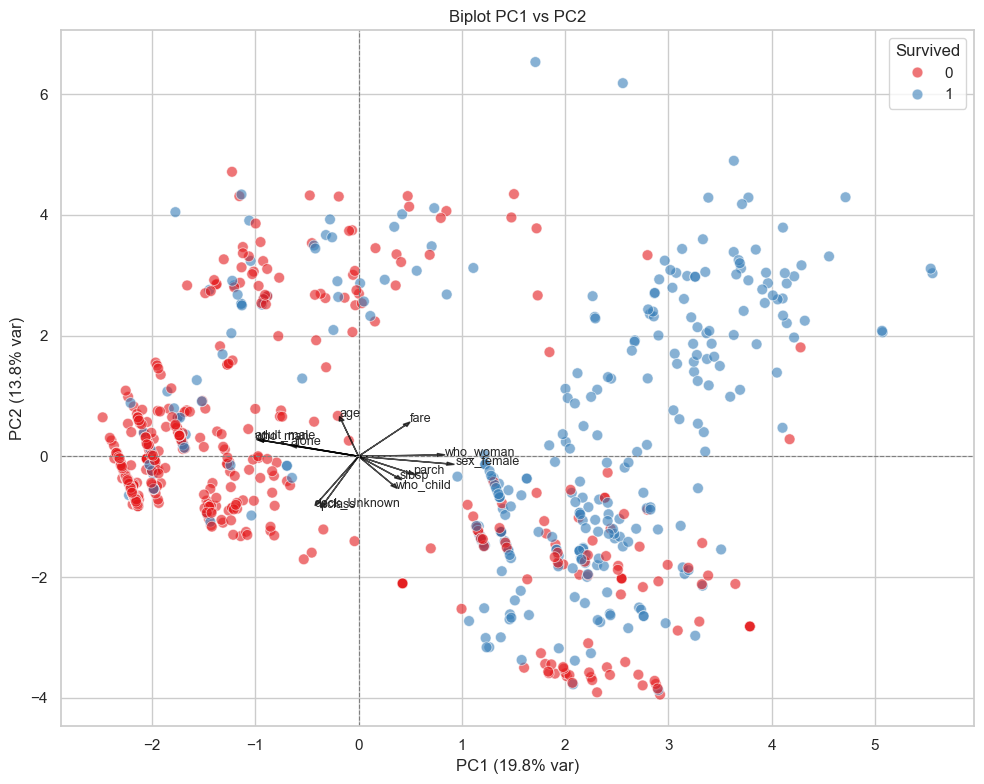

In [10]:
biplot(
    pca_model=pca,
    components_df=df_pca,
    comp_x=1,
    comp_y=2,
    target_series=df_pca['survived'],
    feature_labels=feature_names,
    top_features=12
)

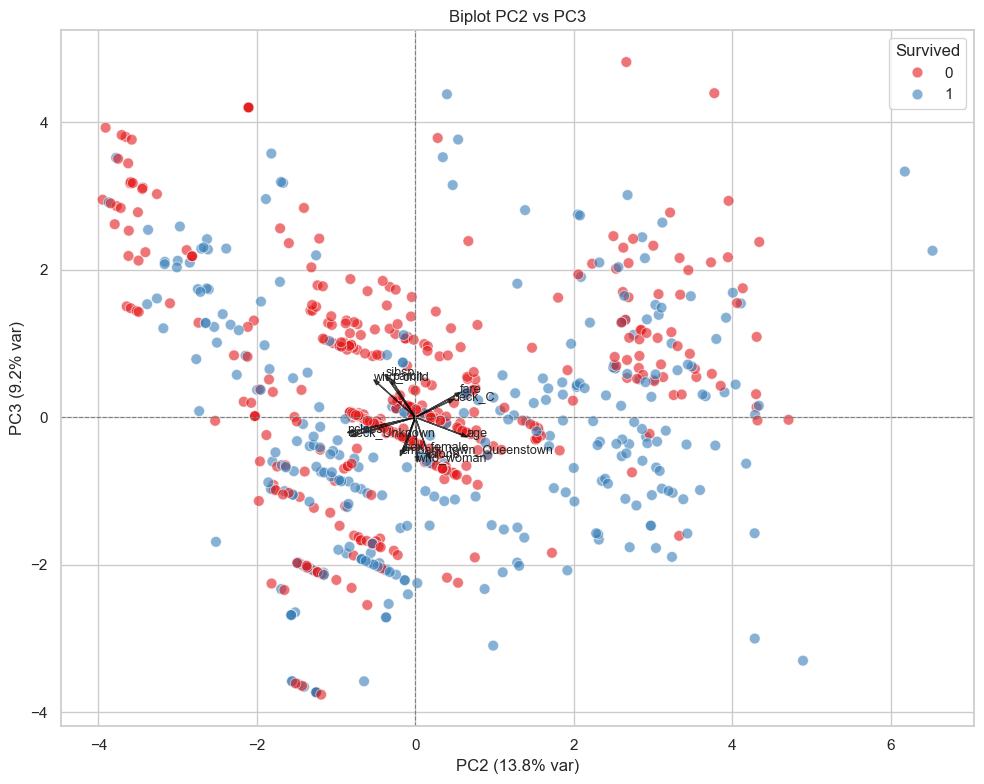

In [11]:
biplot(
    pca_model=pca,
    components_df=df_pca,
    comp_x=2,
    comp_y=3,
    target_series=df_pca['survived'],
    feature_labels=feature_names,
    top_features=12
)

## Importancia de variables en PC1

Se listan las variables con mayor contribución absoluta a la primera componente y se calcula la media de las componentes por supervivencia.

In [12]:
pc1_loadings = pd.Series(pca.components_[0], index=feature_names)
pc1_importance = pc1_loadings.abs().sort_values(ascending=False)
pc1_importance.head(15)

who_man                    0.428098
adult_male                 0.428098
sex_female                 0.399875
who_woman                  0.357109
alone                      0.279217
parch                      0.226851
fare                       0.210885
deck_Unknown               0.181491
sibsp                      0.170434
pclass                     0.157450
who_child                  0.155509
deck_B                     0.119273
embark_town_Cherbourg      0.102423
deck_C                     0.098911
embark_town_Southampton    0.095536
dtype: float64

In [13]:
pc_means = df_pca.groupby('survived')[['PC1', 'PC2', 'PC3']].mean()
pc_means

,PC1,PC2,PC3
survived,,,
0,-0.963973,-0.202319,0.189396
1,1.547430,0.324776,-0.304031


## Interpretación y respuestas

- **Patrones en el biplot PC1 vs PC2:** PC1 separa claramente a los sobrevivientes (valores positivos) de los no sobrevivientes, impulsada por `sex_female`, `who_woman`, tarifas altas y menor número de acompañantes (`alone`). Los valores negativos concentran `who_man`, `adult_male`, `pclass` altos y familias numerosas (`parch`, `sibsp`), alineándose con los pasajeros varones de tercera clase.
- **Representatividad de PC1 y PC2:** PC1 explica ≈20 % y PC2 ≈14 % de la varianza; juntas capturan ~34 %. Al incorporar PC3 la varianza acumulada asciende a ~43 %, lo que sugiere que se necesitan varias componentes para explicar la dispersión completa.
- **Relaciones entre variables (PC1 vs PC2):** `fare` y `deck_Unknown` apuntan junto a `sex_female`, reforzando que tarifas altas y cabinas identificadas se asocian a supervivencia. Por el contrario, `pclass`, `who_man` y `adult_male` apuntan al lado opuesto, remarcando el riesgo de varones de clases bajas. PC2 agrega un gradiente de clase/edad donde `fare` alto y `deck` conocido se separan de familias con hijos (`sibsp`, `parch`).
- **Comparación con el biplot PC2 vs PC3:** PC3 está dominada por los puertos (`embark_town_*`), introduciendo una separación geográfica menos ligada directamente a la supervivencia. Se mantiene el eje de clase/edad de PC2, pero el eje vertical ahora diferencia principalmente Southampton frente a Cherbourg/Queenstown.
- **Variables dominantes en PC1:** Destacan `who_man`, `adult_male`, `sex_female`, `who_woman`, `alone`, `parch`, `fare` y `pclass`, evidenciando que género, composición familiar y clase explican la mayor varianza.
- **Características de los supervivientes:** Las medias positivas en PC1 y PC2 para `survived = 1` indican mayor presencia de mujeres, tarifas altas, viajes con pocas personas a cargo y embarques distintos a Southampton, coherente con las políticas de evacuación "mujeres y niños primero".